random Forest playgroung using the lab in itroduction to statistical learning as a reference

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from sklearn.tree import (DecisionTreeClassifier as DTC, 
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF,
                              GradientBoostingRegressor as GBR,
                              RandomForestClassifier as RFC)
import sklearn.model_selection as skm
from ISLP.models import ModelSpec as MS
from ISLP import load_data, confusion_table


First we load the our smaller data (1std_dataset)
I have two ideas in mind on what to use as a classifier:
First: use "distressed" as a binary classifier; however since there is a very small number of distressed observations
Second: use 'z_score' which is continious as the classifier by setting a threshold and define that a "good" and "bad" here we can move around the threshold and see how the model performs  

In [39]:
df = pd.read_csv("../datasets/1std_dataset.csv")
distressed = np.asarray(df['distressed'].values)
model = MS(df.select_dtypes(include=np.number).columns, intercept=False)
D = model.fit_transform(df)
feature_names = list(D.columns)
X = np.asarray(D)

In [40]:
clf = DTC(criterion='gini', 
          max_depth=30,
          random_state=0)
clf.fit(X, distressed)

DecisionTreeClassifier(max_depth=30, random_state=0)

In [41]:
accuracy_score(distressed, clf.predict(X))

1.0

With distressed the accuracy is 1, which is to be expected, since basically every observation is not distressed. (Out of 667 Observation 8 are distressed)

Let's use Z_score as a classifier now

In [42]:
zscore_save = np.where(df.z_score >= 1.8, 1, 0) 
model = MS(df.select_dtypes(include=np.number).columns.drop('z_score'), intercept=False)
D = model.fit_transform(df)
feature_names = list(D.columns)
X = np.asarray(D)

In [43]:
clf = DTC(criterion='gini', 
          max_depth=3)
clf.fit(X, zscore_save)

DecisionTreeClassifier(max_depth=3)

In [44]:
accuracy_score(zscore_save, clf.predict(X))

0.9415292353823088

for the first iteration we get a highly accurate model with with 7% error rate. This might be indication of an overfit, so we should be careful with the interpretation.

In [45]:
resid_dev = np.sum(log_loss(zscore_save, clf.predict_proba(X)))
resid_dev

0.1969002457042246

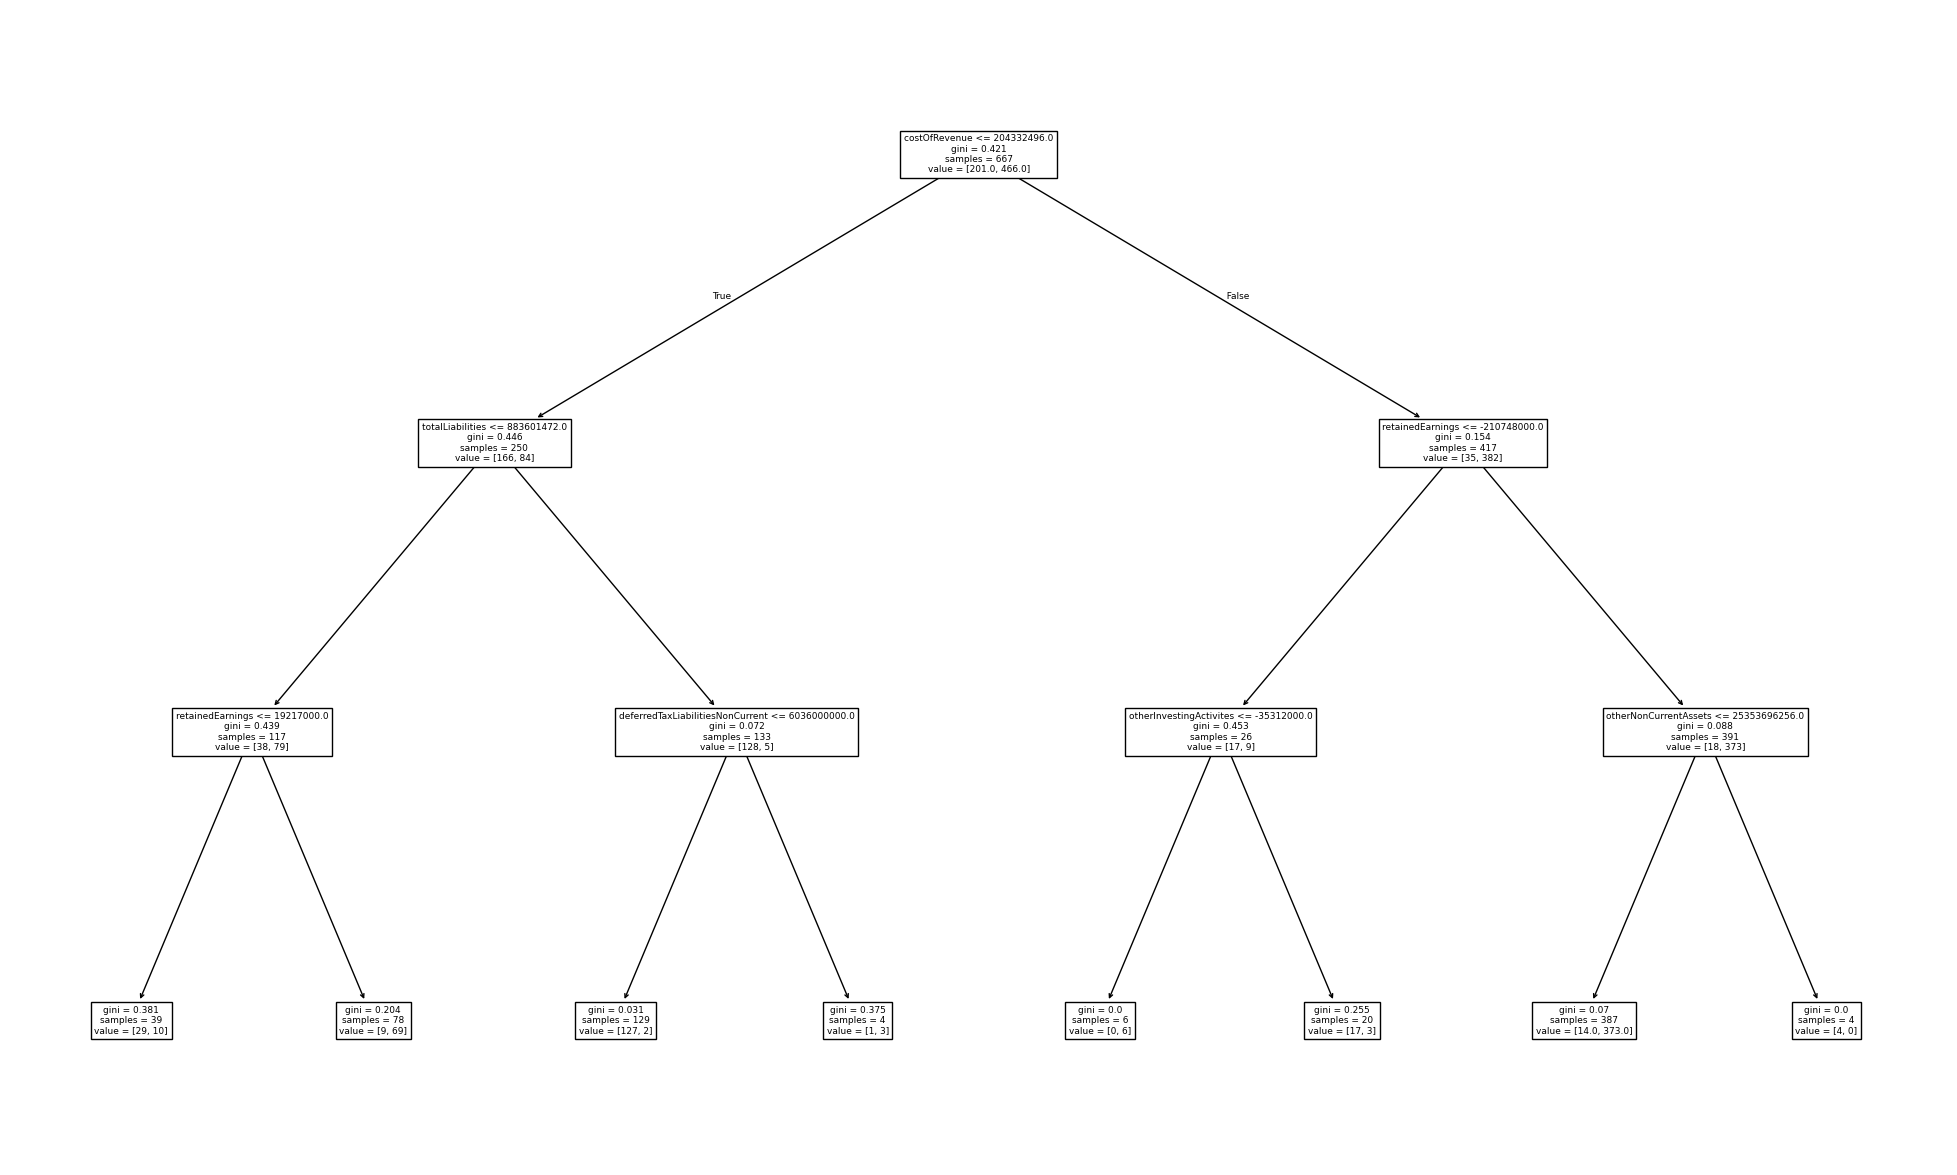

In [46]:
ax = subplots(figsize=(25,15))[1]
plot_tree(clf,
    feature_names=feature_names,
    ax=ax);

In [47]:
print(export_text(clf,
feature_names=feature_names,
show_weights=True))

|--- costOfRevenue <= 204332496.00
|   |--- totalLiabilities <= 883601472.00
|   |   |--- retainedEarnings <= 19217000.00
|   |   |   |--- weights: [29.00, 10.00] class: 0
|   |   |--- retainedEarnings >  19217000.00
|   |   |   |--- weights: [9.00, 69.00] class: 1
|   |--- totalLiabilities >  883601472.00
|   |   |--- deferredTaxLiabilitiesNonCurrent <= 6036000000.00
|   |   |   |--- weights: [127.00, 2.00] class: 0
|   |   |--- deferredTaxLiabilitiesNonCurrent >  6036000000.00
|   |   |   |--- weights: [1.00, 3.00] class: 1
|--- costOfRevenue >  204332496.00
|   |--- retainedEarnings <= -210748000.00
|   |   |--- otherInvestingActivites <= -35312000.00
|   |   |   |--- weights: [0.00, 6.00] class: 1
|   |   |--- otherInvestingActivites >  -35312000.00
|   |   |   |--- weights: [17.00, 3.00] class: 0
|   |--- retainedEarnings >  -210748000.00
|   |   |--- otherNonCurrentAssets <= 25353696256.00
|   |   |   |--- weights: [14.00, 373.00] class: 1
|   |   |--- otherNonCurrentAssets >  25

Cost of revenue seems to be the most important feature in this model

Next, we will split the data into some validation sets and see how the model performs on those

In [48]:
validation = skm.ShuffleSplit(n_splits=5,
                              test_size=0.2,
                              random_state=0)
results = skm.cross_validate(clf,
                             D,
                             zscore_save,
                             cv=validation)
results['test_score']

array([0.87313433, 0.92537313, 0.94029851, 0.93283582, 0.92537313])

The model is still performing well on the vadation sets.

Now let's actually create new models based on training and validations sets 

In [49]:
(X_train,
 X_test,
 zscore_train,
 zscore_test) = skm.train_test_split(X,
                                     zscore_save,
                                     test_size=0.2,
                                     random_state=0)

In [50]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, zscore_train)
accuracy_score(zscore_test, clf.predict(X_test))

0.9402985074626866

In [51]:
ccp_path = clf.cost_complexity_pruning_path(X_train, zscore_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

In [52]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, zscore_train)
grid.best_score_

0.9064640111809922

[Text(0.48863636363636365, 0.9285714285714286, 'costOfRevenue <= 212279000.0\nentropy = 0.882\nsamples = 533\nvalue = [160.0, 373.0]'),
 Text(0.25, 0.7857142857142857, 'interestExpense <= 3134000.0\nentropy = 0.92\nsamples = 203\nvalue = [135, 68]'),
 Text(0.3693181818181818, 0.8571428571428572, 'True  '),
 Text(0.09090909090909091, 0.6428571428571429, 'marketcap <= 135000000.0\nentropy = 0.761\nsamples = 68\nvalue = [15, 53]'),
 Text(0.045454545454545456, 0.5, 'entropy = 0.503\nsamples = 9\nvalue = [8, 1]'),
 Text(0.13636363636363635, 0.5, 'longTermDebt <= 151614376.0\nentropy = 0.525\nsamples = 59\nvalue = [7, 52]'),
 Text(0.09090909090909091, 0.35714285714285715, 'entropy = 0.232\nsamples = 53\nvalue = [2, 51]'),
 Text(0.18181818181818182, 0.35714285714285715, 'entropy = 0.65\nsamples = 6\nvalue = [5, 1]'),
 Text(0.4090909090909091, 0.6428571428571429, 'totalLiabilities <= 864459968.0\nentropy = 0.503\nsamples = 135\nvalue = [120, 15]'),
 Text(0.3181818181818182, 0.5, 'marketcap <= 

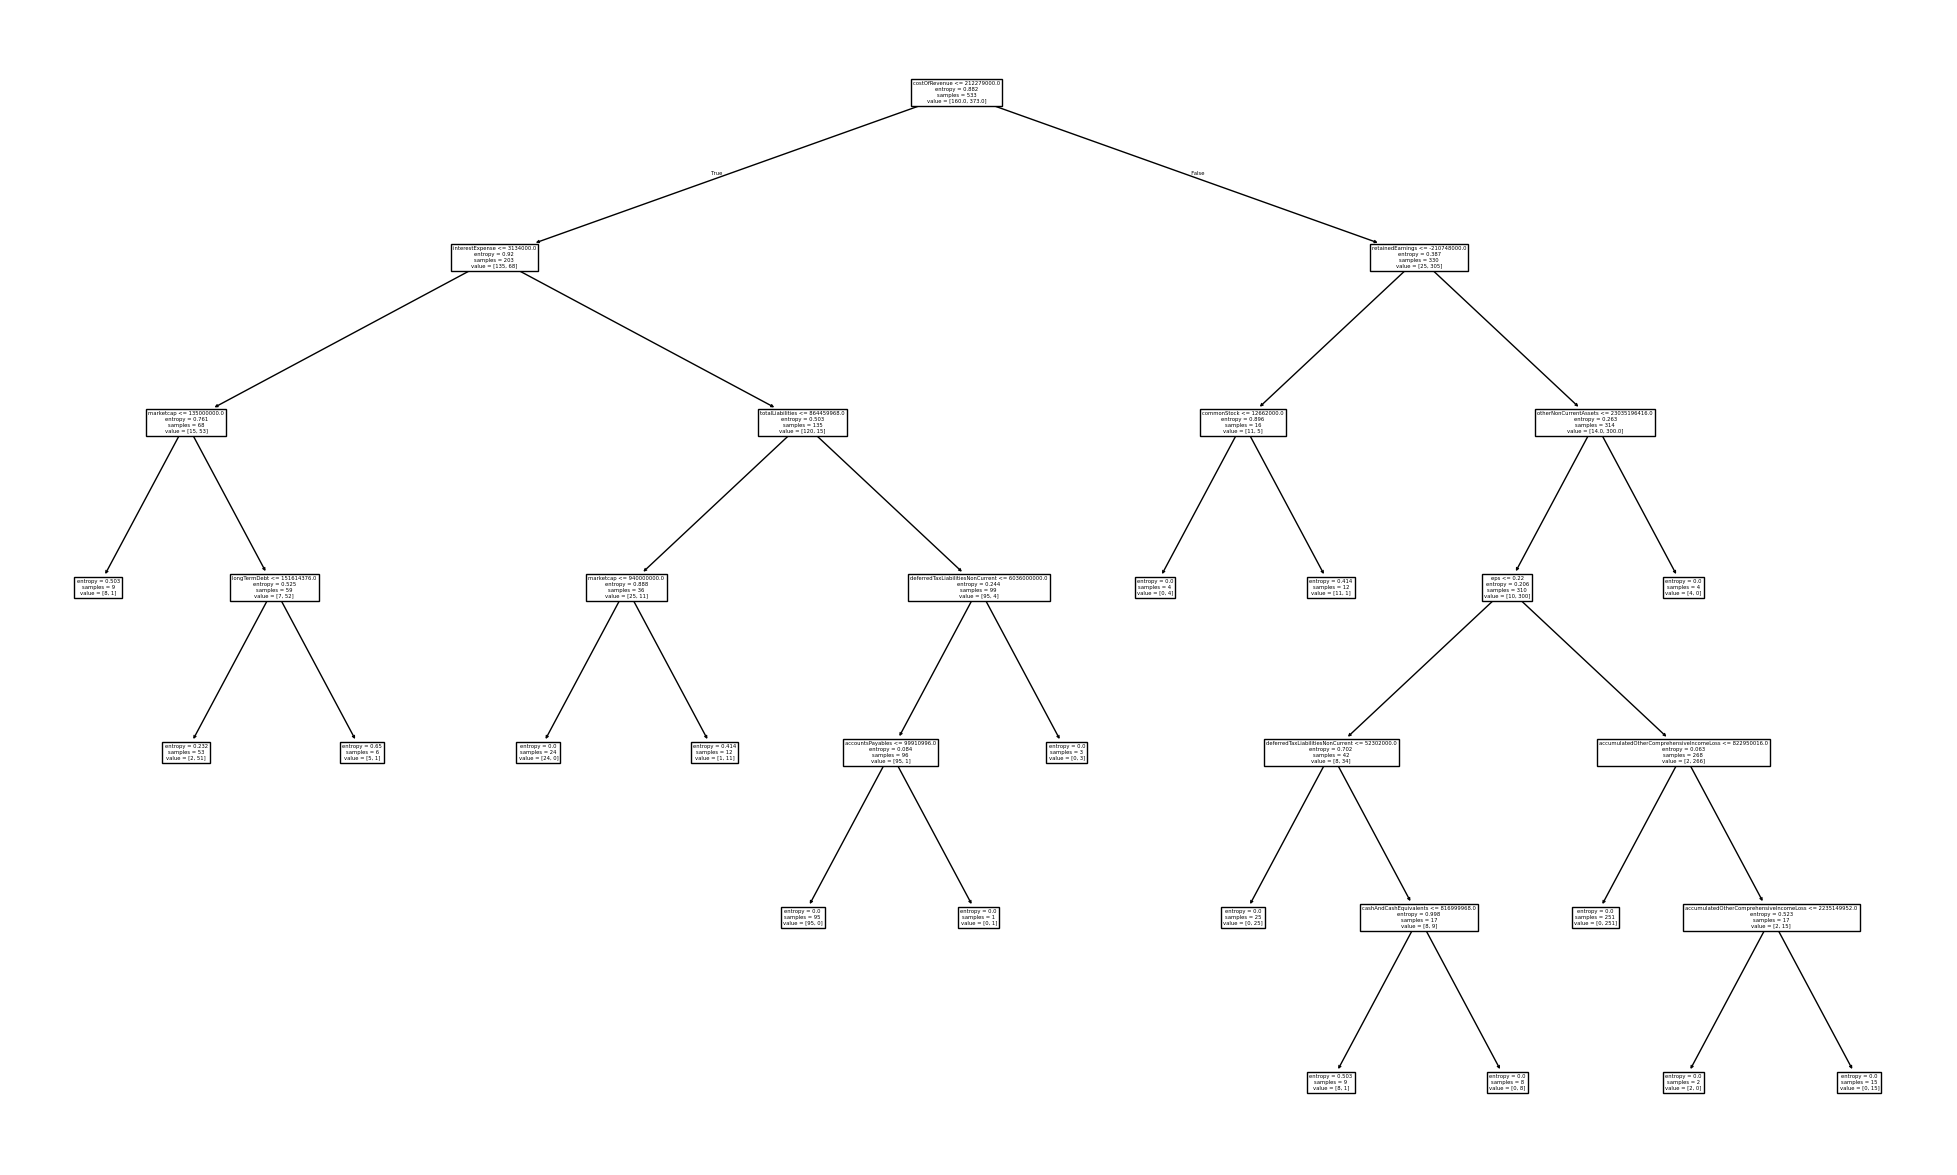

In [53]:
# plot the results of the grid search 
ax = subplots(figsize=(25, 15))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax)

In [54]:
best_.tree_.n_leaves

17

In [55]:
print(accuracy_score(zscore_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            zscore_test)
confusion

0.9253731343283582


Truth,0,1
Predicted,,
0,38,7
1,3,86


This is already a really good result.

Let's attempt to create forests. 1 using the entire dataset and 'distressed' as the classifier and the other with the 3std dataset and 'unhealthy' as the classifier.

In [56]:
#load datasets
df = pd.read_csv("../datasets/full_cleaned_dataset.csv")
df3std = pd.read_csv("../datasets/3std_dataset.csv")

#drop unrequired columns
df3std.drop(columns=['distressed', 'z_score'], inplace=True)

model = MS(df.select_dtypes(include=np.number).columns.drop('distressed'), intercept=False)
D = model.fit_transform(df)
feature_names = list(D.columns)
X = np.asarray(D)

model3std = MS(df3std.select_dtypes(include=np.number).columns.drop('unhealthy'), intercept=False)
E = model3std.fit_transform(df3std)
feature_names3std = list(E.columns)
X3 = np.asarray(E)

In [ ]:
# split the data into training and test sets (30% test size)
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                 df['distressed'],
                                 test_size=0.3,
                                 random_state=0)
 
(X3_train,
 X3_test,
 y3_train,
 y3_test) = skm.train_test_split(X3,
                                 df3std['unhealthy'],
                                 test_size=0.3,
                                 random_state=0,
                                 stratify=)

In [58]:
bag_full = RFC(max_features=X_train.shape[1], random_state=0)
bag_full.fit(X_train, y_train)

bag_3std = RFC(max_features=X3_train.shape[1], random_state=0)
bag_3std.fit(X3_train, y3_train)

RandomForestClassifier(max_features=104, random_state=0)

In [62]:
y_hat_bag = bag_full.predict(X_test)
mse_bag_full_1 = np.mean((y_test - y_hat_bag) ** 2)
print(f"MSE: {mse_bag_full_1}")

MSE: 0.021660649819494584


In [61]:
y3_hat_bag = bag_3std.predict(X3_test)
mse_bag_3std_1 = np.mean((y3_test - y3_hat_bag) ** 2)
print(f"MSE: {mse_bag_3std_1}")

MSE: 0.102803738317757


Initially both models perform well, we can increase the number of trees to see if we can improve the models even further.

In [63]:
# fitting models with 500 trees
bag_full = RFC(max_features=X_train.shape[1], n_estimators=500, random_state=0).fit(X_train, y_train)

bag_3std = RFC(max_features=X3_train.shape[1], n_estimators=500, random_state=0).fit(X3_train, y3_train)

In [64]:
y_hat_bag = bag_full.predict(X_test)
y3_hat_bag = bag_3std.predict(X3_test)

mse_bag_full_2 = np.mean((y_test - y_hat_bag) ** 2)
mse_bag_3std_2 = np.mean((y3_test - y3_hat_bag) ** 2)
print(f"MSE: {mse_bag_full_2}")
print(f"MSE: {mse_bag_3std_2}")

MSE: 0.021660649819494584
MSE: 0.09813084112149532


In [65]:
print(f"in the full dataset MSE went from {mse_bag_full_1} to {mse_bag_full_2}")
print(f"in the 3std dataset MSE went from {mse_bag_3std_1} to {mse_bag_3std_2}")

in the full dataset MSE went from 0.021660649819494584 to 0.021660649819494584
in the 3std dataset MSE went from 0.102803738317757 to 0.09813084112149532


There wasn't much change when just increasing the number of trees.
We can check for the "importance" of the features in the model. Importance is a relative measure

In [66]:
feature_importances = pd.DataFrame({'importance':bag_full.feature_importances_}, index=feature_names)
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(10)

,importance
year,0.304132
retainedEarnings,0.047923
commonStockIssued,0.027505
revenue,0.027259
othertotalStockholdersEquity,0.021909
costAndExpenses,0.019073
operatingIncomeRatio,0.018846
ebitda,0.018579
totalInvestments,0.018434
totalCurrentLiabilities,0.017963


Interestingly, year appears to be the most 'important' feature to determine whether a company is distressed or not.

In [67]:
feature_imp_3std = pd.DataFrame({'importance':bag_3std.feature_importances_}, index=feature_names)
feature_imp_3std.sort_values(by='importance', ascending=False, inplace=True)
feature_imp_3std.head(10)

,importance
costOfRevenue,0.228354
epsdiluted,0.070199
eps,0.054866
netIncomeRatio_income_statement,0.048498
grossProfitRatio,0.047316
interestExpense,0.041211
retainedEarnings,0.032484
totalDebt,0.023850
propertyPlantEquipmentNet,0.023110
marketcap,0.020377


Text(0.5, 1.0, 'Top 10 Features Importance (Gini Index)')

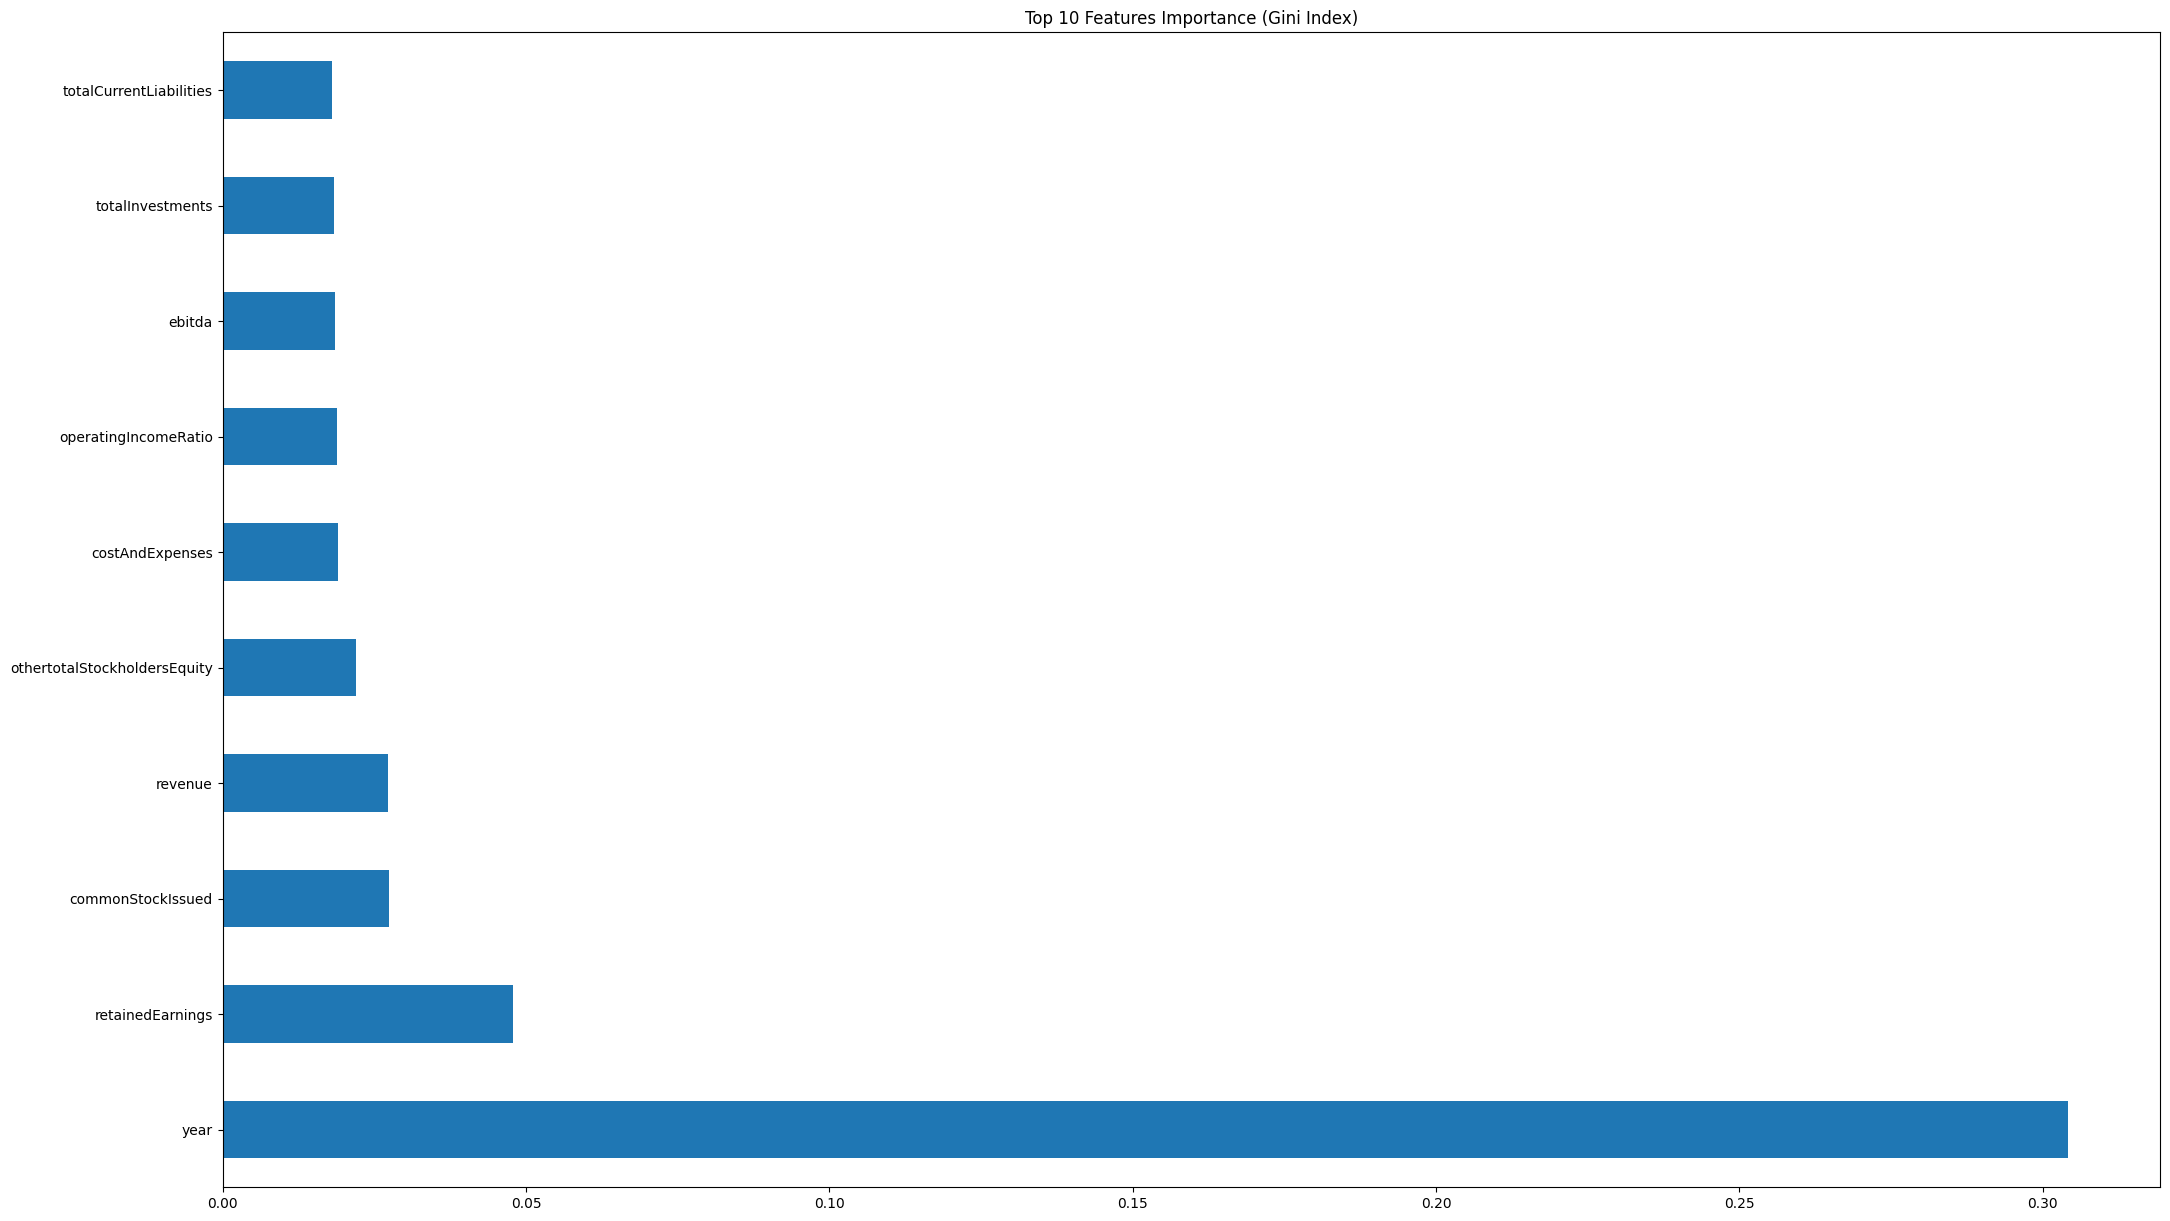

In [68]:
# lets display the gini index for the top 10 features
ax = subplots(figsize=(25, 15))[1]
feature_importances.head(10).plot(kind='barh', ax=ax, legend=False)
ax.set_title('Top 10 Features Importance (Gini Index)')

In [70]:
print(log_loss(y_test, bag_full.predict_proba(X_test)))
print(log_loss(y3_test, bag_3std.predict_proba(X3_test)))

0.04650186648884486
0.25830433630269106


In [87]:
bag_3std.decision_path(X3_test)

(<214x27828 sparse matrix of type '<class 'numpy.int64'>'
 	with 852177 stored elements in Compressed Sparse Row format>,
 array([    0,    51,   102,   163,   218,   279,   334,   401,   462,
          523,   568,   619,   672,   731,   780,   839,   898,   953,
         1006,  1067,  1112,  1157,  1222,  1271,  1310,  1363,  1420,
         1479,  1538,  1591,  1646,  1703,  1758,  1809,  1872,  1923,
         1970,  2029,  2092,  2155,  2218,  2275,  2336,  2397,  2452,
         2511,  2568,  2625,  2678,  2733,  2800,  2861,  2916,  2981,
         3044,  3105,  3154,  3209,  3264,  3321,  3382,  3443,  3488,
         3541,  3584,  3637,  3690,  3741,  3796,  3855,  3912,  3971,
         4022,  4073,  4128,  4195,  4250,  4305,  4360,  4415,  4470,
         4525,  4584,  4641,  4690,  4751,  4808,  4859,  4918,  4975,
         5028,  5083,  5128,  5197,  5256,  5313,  5364,  5425,  5478,
         5527,  5578,  5631,  5682,  5737,  5792,  5851,  5896,  5961,
         6012,  6065,  612

In [ ]:
# Gini importance 
bag_3std.feature_importances_

array([0.00352641, 0.00212768, 0.00224775, 0.00163292, 0.00322481,
       0.00624012, 0.00504467, 0.02310998, 0.00135009, 0.00171175,
       0.00368521, 0.00795441, 0.00203655, 0.01024569, 0.00172966,
       0.00670972, 0.00132147, 0.0024933 , 0.00692946, 0.00196128,
       0.00627645, 0.00509919, 0.00318141, 0.00450143, 0.00329107,
       0.00300077, 0.00253889, 0.00489998, 0.00391963, 0.01167374,
       0.01394517, 0.00112568, 0.01162521, 0.03248435, 0.00232675,
       0.00388707, 0.00197357, 0.00136579, 0.0012035 , 0.01114745,
       0.00125479, 0.00225028, 0.02385024, 0.00577154, 0.00269292,
       0.00347175, 0.00344114, 0.00977337, 0.00274613, 0.0033606 ,
       0.0014447 , 0.00253463, 0.00163362, 0.00321984, 0.01712633,
       0.0013699 , 0.00257395, 0.00205201, 0.0046283 , 0.00290203,
       0.00535721, 0.00175277, 0.00223922, 0.00342949, 0.00267633,
       0.00304856, 0.00460995, 0.00150757, 0.00247827, 0.0012454 ,
       0.00178426, 0.01697509, 0.00134833, 0.00457457, 0.00245

In [86]:
bag_3std.predict_log_proba(X3_test)

c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:994: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


array([[-1.01611107e+00, -4.49416996e-01],
       [-5.76291128e-02, -2.88240359e+00],
       [-1.23298216e-01, -2.15416509e+00],
       [-2.85018955e-01, -1.39432653e+00],
       [-9.57112726e-01, -4.84508315e-01],
       [-5.34435489e-01, -8.81889305e-01],
       [-2.82362911e-01, -1.40242374e+00],
       [-1.26584821e+00, -3.31285710e-01],
       [-3.12356565e+00, -4.49973659e-02],
       [           -inf,  0.00000000e+00],
       [-6.40053300e-02, -2.78062089e+00],
       [-6.18754037e-02, -2.81341072e+00],
       [-2.56183405e-01, -1.48722028e+00],
       [-1.61293819e-02, -4.13516656e+00],
       [-4.91902442e-02, -3.03655427e+00],
       [-1.07880966e+00, -4.15515444e-01],
       [-5.44727175e-01, -8.67500568e-01],
       [-5.55127099e-02, -2.91877123e+00],
       [-2.83994745e-02, -3.57555077e+00],
       [-7.80886095e-01, -6.12489278e-01],
       [-3.12356565e+00, -4.49973659e-02],
       [-4.82831374e+00, -8.03217170e-03],
       [-3.53821875e-01, -1.21066179e+00],
       [-9.

In [85]:
bag_3std.predict_proba(X3_test)

array([[0.362, 0.638],
       [0.944, 0.056],
       [0.884, 0.116],
       [0.752, 0.248],
       [0.384, 0.616],
       [0.586, 0.414],
       [0.754, 0.246],
       [0.282, 0.718],
       [0.044, 0.956],
       [0.   , 1.   ],
       [0.938, 0.062],
       [0.94 , 0.06 ],
       [0.774, 0.226],
       [0.984, 0.016],
       [0.952, 0.048],
       [0.34 , 0.66 ],
       [0.58 , 0.42 ],
       [0.946, 0.054],
       [0.972, 0.028],
       [0.458, 0.542],
       [0.044, 0.956],
       [0.008, 0.992],
       [0.702, 0.298],
       [0.908, 0.092],
       [0.09 , 0.91 ],
       [0.108, 0.892],
       [1.   , 0.   ],
       [0.818, 0.182],
       [0.992, 0.008],
       [0.062, 0.938],
       [0.848, 0.152],
       [0.936, 0.064],
       [0.472, 0.528],
       [0.424, 0.576],
       [0.082, 0.918],
       [0.674, 0.326],
       [0.404, 0.596],
       [0.59 , 0.41 ],
       [0.16 , 0.84 ],
       [1.   , 0.   ],
       [0.488, 0.512],
       [0.972, 0.028],
       [0.296, 0.704],
       [0.0

In [ ]:
# mean accuracy
print(bag_full.score(X_test, y_test))
print(bag_3std.score(X3_test, y3_test))

0.9783393501805054
0.9018691588785047


In [90]:
y_test_pred = bag_full.predict(X_test)
confusion_table(y_test, y_test_pred)

Truth,0,1
Predicted,,
0,267,0
1,6,4


In [91]:
y3_test_pred = bag_3std.predict(X3_test)
confusion_table(y3_test, y3_test_pred)

Truth,0.0,1.0
Predicted,,
0.0,109,5
1.0,16,84
